In [526]:
from datetime import date, datetime, timedelta

from binance.binance_k_line_repository import load_k_lines

interval_days = 14
interval_minutes = interval_days * 24 * 60
interval_date_from: date = date.today() - timedelta(days=3 + interval_days - 1)
interval_date_to: date = date.today() - timedelta(days=3)

symbol: str = "ETHUSDT"

raw_k_lines = load_k_lines(symbol, interval_date_from, interval_date_to)

display(raw_k_lines)

,open_timestamp_millis,open_price,high_price,low_price,close_price,volume,close_timestamp_millis,quote_asset_volume,trades_count,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1684368000000,1821.65,1822.26,1821.12,1822.12,3084.265,1684368059999,5.619013e+06,2300,1780.901,3.244590e+06,0
1,1684368060000,1822.12,1822.22,1820.17,1820.17,3485.401,1684368119999,6.347204e+06,2289,741.655,1.350848e+06,0
2,1684368120000,1820.18,1820.33,1820.01,1820.26,1461.193,1684368179999,2.659546e+06,1357,769.967,1.401439e+06,0
3,1684368180000,1820.26,1820.27,1820.00,1820.13,844.727,1684368239999,1.537443e+06,818,477.473,8.690201e+05,0
4,1684368240000,1820.14,1820.99,1819.99,1820.14,2024.624,1684368299999,3.685326e+06,1471,1057.472,1.924865e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1685577300000,1873.17,1874.41,1873.08,1874.41,4202.478,1685577359999,7.873024e+06,1590,2667.404,4.997601e+06,0
1436,1685577360000,1874.40,1874.41,1872.54,1872.80,3444.416,1685577419999,6.454170e+06,1565,401.812,7.527455e+05,0
1437,1685577420000,1872.81,1873.44,1872.64,1872.84,1423.699,1685577479999,2.666499e+06,1428,820.822,1.537314e+06,0
1438,1685577480000,1872.84,1872.95,1872.53,1872.83,820.012,1685577539999,1.535584e+06,910,353.406,6.618053e+05,0


In [527]:
import pandas as pd

k_lines = raw_k_lines[["close_price"]]
k_lines.index = pd.to_datetime(raw_k_lines["open_timestamp_millis"], unit="ms")
k_lines.index.name = "open_datetime"

k_lines

,close_price
open_datetime,
2023-05-18 00:00:00,1822.12
2023-05-18 00:01:00,1820.17
2023-05-18 00:02:00,1820.26
2023-05-18 00:03:00,1820.13
2023-05-18 00:04:00,1820.14
...,...
2023-05-31 23:55:00,1874.41
2023-05-31 23:56:00,1872.80
2023-05-31 23:57:00,1872.84


In [528]:
from numpy import float16, float64

# TODO: revivce disabled validations

# assert len(k_lines) == interval_minutes

assert len(k_lines[k_lines.isna().any(axis=1)]) == 0
assert len(k_lines[k_lines.isnull().any(axis=1)]) == 0

assert k_lines.dtypes["close_price"] == float64
assert len(k_lines[k_lines["close_price"] <= 0]) == 0

# display(
#     (
#     (k_lines.index.to_series() - k_lines.index.to_series().shift(1))
#     .iloc[1:]
#     .dt.total_seconds()
#     ).value_counts()

# )

# assert (
#     (k_lines.index.to_series() - k_lines.index.to_series().shift(1))
#     .iloc[1:]
#     .dt.total_seconds()
#     == 60
# ).all()

<Axes: xlabel='open_datetime'>

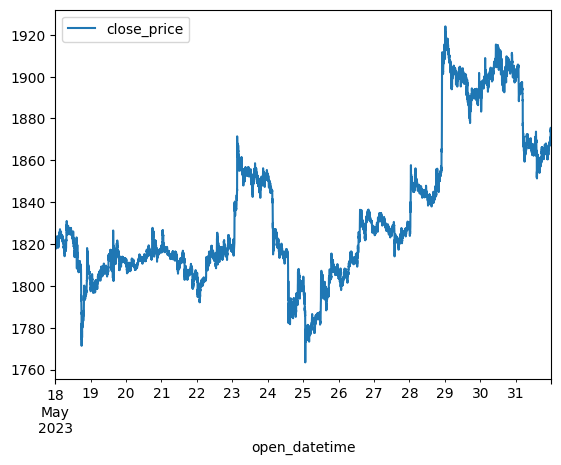

In [529]:
k_lines.plot.line(use_index=True)

In [530]:
k_lines_features = k_lines.copy()

k_lines_features["previous_close_price_mean_1_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(1).mean()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_mean_2_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(2).mean()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_mean_4_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(4).mean()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_mean_8_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(8).mean()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_mean_16_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(16).mean()
    / k_lines_features["close_price"]
)

k_lines_features["previous_close_price_std_2_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(2).std()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_std_4_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(4).std()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_std_8_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(8).std()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_std_16_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(16).std()
    / k_lines_features["close_price"]
)

k_lines_features["previous_close_price_min_2_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(2).min()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_min_4_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(4).min()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_min_8_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(8).min()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_min_16_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(16).min()
    / k_lines_features["close_price"]
)

k_lines_features["previous_close_price_max_2_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(2).max()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_max_4_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(4).max()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_max_8_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(8).max()
    / k_lines_features["close_price"]
)
k_lines_features["previous_close_price_max_16_ratio"] = (
    k_lines_features["close_price"].shift(1).rolling(16).max()
    / k_lines_features["close_price"]
)


k_lines_features["is_next_close_price_greater"] = (
    k_lines_features["close_price"]
    .shift(-1)
    .rolling(2)
    .apply(lambda x: x.iloc[1] > x.iloc[0])
)

k_lines_features.dropna(inplace=True)

display(k_lines_features)

,close_price,previous_close_price_mean_1_ratio,previous_close_price_mean_2_ratio,previous_close_price_mean_4_ratio,previous_close_price_mean_8_ratio,previous_close_price_mean_16_ratio,previous_close_price_std_2_ratio,previous_close_price_std_4_ratio,previous_close_price_std_8_ratio,previous_close_price_std_16_ratio,previous_close_price_min_2_ratio,previous_close_price_min_4_ratio,previous_close_price_min_8_ratio,previous_close_price_min_16_ratio,previous_close_price_max_2_ratio,previous_close_price_max_4_ratio,previous_close_price_max_8_ratio,previous_close_price_max_16_ratio,is_next_close_price_greater
open_datetime,,,,,,,,,,,,,,,,,,,
2023-05-18 00:16:00,1820.91,1.000280,0.999712,0.999385,0.999187,0.999566,0.000804,0.000608,0.000464,0.000585,0.999143,0.998924,0.998825,0.998825,1.000280,1.000280,1.000280,1.000665,1.0
2023-05-18 00:17:00,1822.49,0.999133,0.999273,0.998787,0.998420,0.998658,0.000198,0.000573,0.000546,0.000522,0.999133,0.998277,0.997959,0.997959,0.999413,0.999413,0.999413,0.999621,1.0
2023-05-18 00:18:00,1822.80,0.999830,0.999397,0.999036,0.998506,0.998568,0.000613,0.000717,0.000741,0.000621,0.998963,0.998107,0.997860,0.997789,0.999830,0.999830,0.999830,0.999830,0.0
2023-05-18 00:19:00,1822.55,1.000137,1.000052,0.999646,0.998910,0.998792,0.000120,0.000488,0.000853,0.000717,0.999967,0.999100,0.998025,0.997926,1.000137,1.000137,1.000137,1.000137,0.0
2023-05-18 00:20:00,1820.34,1.001214,1.001283,1.001015,1.000356,1.000088,0.000097,0.000474,0.000866,0.000777,1.001214,1.000313,0.999236,0.999138,1.001351,1.001351,1.001351,1.001351,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:54:00,1873.18,1.000016,1.000096,1.000312,1.000352,0.999961,0.000113,0.000374,0.000310,0.000927,1.000016,1.000016,1.000016,0.998350,1.000176,1.000860,1.000860,1.001265,1.0
2023-05-31 23:55:00,1874.41,0.999344,0.999352,0.999441,0.999595,0.999408,0.000011,0.000104,0.000269,0.000821,0.999344,0.999344,0.999344,0.998031,0.999360,0.999541,1.000203,1.000608,0.0
2023-05-31 23:56:00,1872.80,1.000860,1.000531,1.000415,1.000505,1.000390,0.000464,0.000307,0.000305,0.000746,1.000203,1.000203,1.000203,0.998889,1.000860,1.000860,1.001063,1.001468,1.0


In [531]:
test_k_lines_ratio = 0.2
test_k_lines_count = round(test_k_lines_ratio * len(k_lines_features))

train_k_lines_features = k_lines_features.iloc[:-test_k_lines_count]
test_k_lines_features = k_lines_features.iloc[-test_k_lines_count:]

display(train_k_lines_features)
display(test_k_lines_features)

,close_price,previous_close_price_mean_1_ratio,previous_close_price_mean_2_ratio,previous_close_price_mean_4_ratio,previous_close_price_mean_8_ratio,previous_close_price_mean_16_ratio,previous_close_price_std_2_ratio,previous_close_price_std_4_ratio,previous_close_price_std_8_ratio,previous_close_price_std_16_ratio,previous_close_price_min_2_ratio,previous_close_price_min_4_ratio,previous_close_price_min_8_ratio,previous_close_price_min_16_ratio,previous_close_price_max_2_ratio,previous_close_price_max_4_ratio,previous_close_price_max_8_ratio,previous_close_price_max_16_ratio,is_next_close_price_greater
open_datetime,,,,,,,,,,,,,,,,,,,
2023-05-18 00:16:00,1820.91,1.000280,0.999712,0.999385,0.999187,0.999566,0.000804,0.000608,0.000464,0.000585,0.999143,0.998924,0.998825,0.998825,1.000280,1.000280,1.000280,1.000665,1.0
2023-05-18 00:17:00,1822.49,0.999133,0.999273,0.998787,0.998420,0.998658,0.000198,0.000573,0.000546,0.000522,0.999133,0.998277,0.997959,0.997959,0.999413,0.999413,0.999413,0.999621,1.0
2023-05-18 00:18:00,1822.80,0.999830,0.999397,0.999036,0.998506,0.998568,0.000613,0.000717,0.000741,0.000621,0.998963,0.998107,0.997860,0.997789,0.999830,0.999830,0.999830,0.999830,0.0
2023-05-18 00:19:00,1822.55,1.000137,1.000052,0.999646,0.998910,0.998792,0.000120,0.000488,0.000853,0.000717,0.999967,0.999100,0.998025,0.997926,1.000137,1.000137,1.000137,1.000137,0.0
2023-05-18 00:20:00,1820.34,1.001214,1.001283,1.001015,1.000356,1.000088,0.000097,0.000474,0.000866,0.000777,1.001214,1.000313,0.999236,0.999138,1.001351,1.001351,1.001351,1.001351,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-29 04:45:00,1896.41,1.000359,0.999808,0.999376,0.999279,1.000057,0.000779,0.000701,0.000502,0.000933,0.999256,0.998698,0.998698,0.998698,1.000359,1.000359,1.000359,1.001587,0.0
2023-05-29 04:46:00,1896.24,1.000090,1.000269,0.999668,0.999459,1.000086,0.000254,0.000745,0.000563,0.000901,1.000090,0.998787,0.998787,0.998787,1.000448,1.000448,1.000448,1.001677,1.0
2023-05-29 04:47:00,1896.63,0.999794,0.999839,0.999765,0.999383,0.999786,0.000063,0.000459,0.000551,0.000817,0.999794,0.999141,0.998582,0.998582,0.999884,1.000243,1.000243,1.001471,0.0


,close_price,previous_close_price_mean_1_ratio,previous_close_price_mean_2_ratio,previous_close_price_mean_4_ratio,previous_close_price_mean_8_ratio,previous_close_price_mean_16_ratio,previous_close_price_std_2_ratio,previous_close_price_std_4_ratio,previous_close_price_std_8_ratio,previous_close_price_std_16_ratio,previous_close_price_min_2_ratio,previous_close_price_min_4_ratio,previous_close_price_min_8_ratio,previous_close_price_min_16_ratio,previous_close_price_max_2_ratio,previous_close_price_max_4_ratio,previous_close_price_max_8_ratio,previous_close_price_max_16_ratio,is_next_close_price_greater
open_datetime,,,,,,,,,,,,,,,,,,,
2023-05-29 04:50:00,1895.41,1.000243,1.000361,1.000451,1.000278,1.000224,0.000168,0.000165,0.000533,0.000586,1.000243,1.000243,0.999224,0.999224,1.000480,1.000644,1.000886,1.001155,1.0
2023-05-29 04:51:00,1895.97,0.999705,0.999826,1.000046,1.000080,0.999856,0.000172,0.000281,0.000354,0.000532,0.999705,0.999705,0.999488,0.998929,0.999947,1.000348,1.000591,1.000643,0.0
2023-05-29 04:52:00,1895.78,1.000100,0.999953,1.000059,1.000244,0.999916,0.000209,0.000198,0.000268,0.000492,0.999805,0.999805,0.999805,0.999029,1.000100,1.000285,1.000691,1.000691,0.0
2023-05-29 04:53:00,1895.44,1.000179,1.000229,1.000168,1.000337,1.000064,0.000071,0.000129,0.000208,0.000466,1.000179,0.999984,0.999984,0.999209,1.000280,1.000280,1.000628,1.000871,0.0
2023-05-29 04:54:00,1895.00,1.000232,1.000322,1.000343,1.000505,1.000309,0.000127,0.000143,0.000225,0.000461,1.000232,1.000216,1.000216,0.999441,1.000412,1.000512,1.000860,1.001103,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 23:54:00,1873.18,1.000016,1.000096,1.000312,1.000352,0.999961,0.000113,0.000374,0.000310,0.000927,1.000016,1.000016,1.000016,0.998350,1.000176,1.000860,1.000860,1.001265,1.0
2023-05-31 23:55:00,1874.41,0.999344,0.999352,0.999441,0.999595,0.999408,0.000011,0.000104,0.000269,0.000821,0.999344,0.999344,0.999344,0.998031,0.999360,0.999541,1.000203,1.000608,0.0
2023-05-31 23:56:00,1872.80,1.000860,1.000531,1.000415,1.000505,1.000390,0.000464,0.000307,0.000305,0.000746,1.000203,1.000203,1.000203,0.998889,1.000860,1.000860,1.001063,1.001468,1.0


In [532]:
from sklearn.ensemble import RandomForestClassifier

model_input_columns = [
    "close_price",
    "previous_close_price_mean_1_ratio",
    "previous_close_price_mean_2_ratio",
    "previous_close_price_mean_4_ratio",
    "previous_close_price_mean_8_ratio",
    "previous_close_price_mean_16_ratio",
    "previous_close_price_std_2_ratio",
    "previous_close_price_std_4_ratio",
    "previous_close_price_std_8_ratio",
    "previous_close_price_std_16_ratio",
    "previous_close_price_min_2_ratio",
    "previous_close_price_min_4_ratio",
    "previous_close_price_min_8_ratio",
    "previous_close_price_min_16_ratio",
    "previous_close_price_max_2_ratio",
    "previous_close_price_max_4_ratio",
    "previous_close_price_max_8_ratio",
    "previous_close_price_max_16_ratio",
]
model_target_column = "is_next_close_price_greater"

model_train_input_values = train_k_lines_features[model_input_columns]
model_train_target_values = train_k_lines_features[model_target_column]
model_test_input_values = test_k_lines_features[model_input_columns]
model_test_target_values = test_k_lines_features[model_target_column]

model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=300,
    random_state=1,
)
model.fit(model_train_input_values, model_train_target_values)

model_test_predicted_values = pd.Series(
    model.predict(model_test_input_values), index=test_k_lines_features.index
)
model_train_predicted_values = pd.Series(
    model.predict(model_train_input_values), index=train_k_lines_features.index
)

model_test_predicted_values.name = f"predicted_{model_target_column}"
model_test_target_and_predicted_values = pd.concat(
    [model_test_target_values, model_test_predicted_values], axis=1
)
# display(model_test_target_and_predicted_values)

In [533]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

display(
    "test_accuracy_score = "
    + str(accuracy_score(model_test_target_values, model_test_predicted_values))
)

display(
    "train_accuracy_score = "
    + str(accuracy_score(model_train_target_values, model_train_predicted_values))
)

display(
    "test_precision_score = "
    + str(precision_score(model_test_target_values, model_test_predicted_values))
)

display(
    "train_precision_score = "
    + str(precision_score(model_train_target_values, model_train_predicted_values))
)


# display(precision_score(model_test_target_values, model_test_predicted_values))
# display(recall_score(model_test_target_values, model_test_predicted_values))
# display(f1_score(model_test_target_values, model_test_predicted_values))

'test_accuracy_score = 0.5184909406800695'

'train_accuracy_score = 0.6787886310040958'

'test_precision_score = 0.5512422360248447'

'train_precision_score = 0.7299517771030541'

In [534]:
display(
    pd.concat(
        [
            model_test_target_values.value_counts(),
            model_test_predicted_values.value_counts(),
        ],
        axis=1,
    )
)

,is_next_close_price_greater,predicted_is_next_close_price_greater
0.0,2023,3385
1.0,2006,644
